In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
df = pd.read_csv("cleaned_tweets.csv")
df.dropna(inplace=True)

In [ ]:
df

,Tweet,Label
0,little throwback favourite person water wall,0
1,glam yesterday kcon makeup featherette,7
2,democracy plaza wake stunning outcome decision...,11
3,amp vilo walt disney magic kingdom,0
4,galaxy far far away,2
...,...,...
49995,ootd love chain new ring putaringonit odesigne...,1
49996,met santa olaf north pole today north pole...,0
49997,new york night strideby herelocationnyc seemyc...,11
49998,kiss birthday girl helzberg diamond,0


In [ ]:
X = df["Tweet"].values
y = df["Label"].values

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['Tweet'].values.reshape(-1, 1), df['Label'])


In [ ]:
df_resampled = pd.DataFrame({'Tweet': X_resampled.flatten(), 'Label': y_resampled})


In [ ]:
max_len=40
max_words = 80000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_resampled['Tweet'])
X_seqs = tokenizer.texts_to_sequences(df_resampled['Tweet'])
X_padded = pad_sequences(X_seqs, maxlen=max_len, padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, df_resampled['Label'], test_size=0.2, random_state=42)

num_classes = len(np.unique(df_resampled['Label']))

embedding_dim = 50
gru_units = 64

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X_padded.shape[1]))
model.add(GRU(gru_units))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)


In [ ]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/20
5379/5379 [==============================] - 451s 83ms/step - loss: 2.9969 - accuracy: 0.0497 - val_loss: 2.9969 - val_accuracy: 0.0506
Epoch 2/20
5379/5379 [==============================] - 411s 76ms/step - loss: 2.9966 - accuracy: 0.0495 - val_loss: 2.9965 - val_accuracy: 0.0492
Epoch 3/20
5379/5379 [==============================] - 402s 75ms/step - loss: 2.9966 - accuracy: 0.0506 - val_loss: 2.9965 - val_accuracy: 0.0476
Epoch 4/20
5379/5379 [==============================] - 418s 78ms/step - loss: 2.9965 - accuracy: 0.0492 - val_loss: 2.9963 - val_accuracy: 0.0494
Epoch 5/20
5379/5379 [==============================] - 397s 74ms/step - loss: 2.9965 - accuracy: 0.0501 - val_loss: 2.9963 - val_accuracy: 0.0502
Epoch 6/20
5379/5379 [==============================] - 419s 78ms/step - loss: 2.9964 - accuracy: 0.0495 - val_loss: 2.9966 - val_accuracy: 0.0502
Epoch 7/20
5379/5379 [==============================] - 424s 79ms/step - loss: 2.9963 - accuracy: 0.0501 - val_loss: 2

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            4000000   
                                                                 
 gru (GRU)                   (None, 64)                22272     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 4023572 (15.35 MB)
Trainable params: 4023572 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.save("emojiPred_gruModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, predictions))

1345/1345 [==============================] - 10s 7ms/step
              precision    recall  f1-score   support

           0       0.10      0.27      0.15      2127
           1       0.37      0.39      0.38      2050
           2       0.37      0.35      0.36      2159
           3       0.67      0.50      0.57      2127
           4       0.35      0.58      0.44      2136
           5       0.84      0.56      0.68      2170
           6       0.89      0.58      0.71      2109
           7       0.59      0.55      0.57      2174
           8       0.84      0.69      0.76      2193
           9       0.77      0.65      0.71      2163
          10       0.67      0.70      0.69      2145
          11       0.89      0.75      0.81      2144
          12       0.80      0.77      0.79      2118
          13       0.82      0.72      0.77      2177
          14       0.86      0.75      0.80      2215
          15       0.79      0.80      0.79      2174
          16       0.83

In [ ]:
# batch_size=128
# model.evaluate(X_test, y_test, batch_size=batch_size)

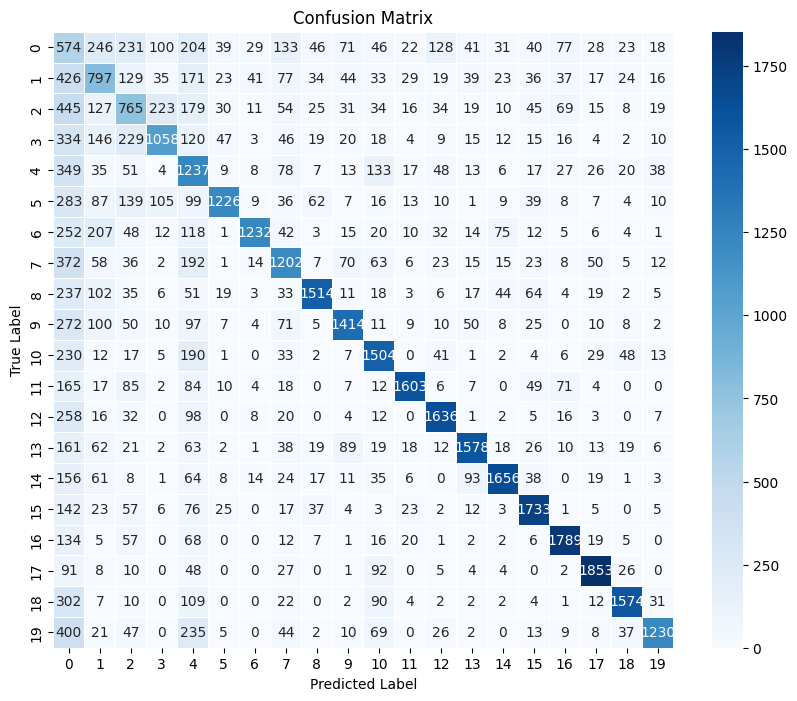

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import re
import string
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

model = load_model('emojiPred_gruModel.h5')

emoji_mapping = {}
with open('_mapping.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip().split()
        label, emoji = int(line[0]), line[1]
        emoji_mapping[label] = emoji

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)  # Remove mentions
    tweet = re.sub(r'RT\s+', '', tweet)  # Remove retweets
    tweet = re.sub(r'https?://[A-Za-z0-9./]+', '', tweet)  # Remove URLs
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Remove extra spaces
    return tweet

input_tweet = "Parvez sir seems the toughest one to deal with"

# Preprocess the input tweet
cleaned_tweet = clean_tweet(input_tweet)

max_len = 40
tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts([cleaned_tweet])
input_sequence = tokenizer.texts_to_sequences([cleaned_tweet])
padded_input = pad_sequences(input_sequence, padding='post', maxlen=max_len)

predicted_label = np.argmax(model.predict(padded_input), axis=1)[0]

predicted_emoji = emoji_mapping.get(predicted_label, 'Unknown')

# Display the results
print(f"Input Tweet: {input_tweet}")
print(f"Predicted Emoji: {predicted_emoji}")


1/1 [==============================] - 1s 1s/step
Input Tweet: i aam sad
Predicted Emoji: ❤️
